<a href="https://colab.research.google.com/github/MarianaCarolynCruz/ArtResults/blob/main/Experiments_ResultsPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
#Carga y preprocesamiento de datos
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Cargar los datos
file_path = 'CASOS_ZONAS.csv'
data = pd.read_csv(file_path)

# Convertir las fechas a un formato datetime
data['fecha'] = pd.to_datetime(data['fecha'], format='%d/%m/%Y')

# Codificar variables categóricas
label_encoder = LabelEncoder()
data['tipo_violencia'] = label_encoder.fit_transform(data['tipo_violencia'])

# Seleccionar características y objetivo
features = data.drop(columns=['fecha', 'gravedad'])
target = data['gravedad']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Mostrar la forma de los conjuntos de datos
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


((146, 7), (37, 7), (146,), (37,))

In [46]:
#Entrenamiento del modelo
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Entrenar el modelo de Bosque Aleatorio
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Realizar predicciones
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Evaluar el modelo
classification_rep_rf = classification_report(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

classification_rep_rf, roc_auc_rf


('              precision    recall  f1-score   support\n\n           0       1.00      0.93      0.96        14\n           1       0.96      1.00      0.98        23\n\n    accuracy                           0.97        37\n   macro avg       0.98      0.96      0.97        37\nweighted avg       0.97      0.97      0.97        37\n',
 0.9503105590062111)

In [47]:
#Mejora del modelo Ajuste de hiperparámetros con Grid Search
from sklearn.model_selection import GridSearchCV

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo de Random Forest
rf = RandomForestClassifier(random_state=42)

# Configurar Grid Search con validación cruzada
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc', verbose=2)

# Ejecutar Grid Search
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_rf = grid_search.best_estimator_

# Realizar predicciones con el mejor modelo
y_pred_best_rf = best_rf.predict(X_test)
y_prob_best_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluar el mejor modelo
classification_rep_best_rf = classification_report(y_test, y_pred_best_rf)
roc_auc_best_rf = roc_auc_score(y_test, y_prob_best_rf)

classification_rep_best_rf, roc_auc_best_rf


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


('              precision    recall  f1-score   support\n\n           0       1.00      0.93      0.96        14\n           1       0.96      1.00      0.98        23\n\n    accuracy                           0.97        37\n   macro avg       0.98      0.96      0.97        37\nweighted avg       0.97      0.97      0.97        37\n',
 0.9503105590062112)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


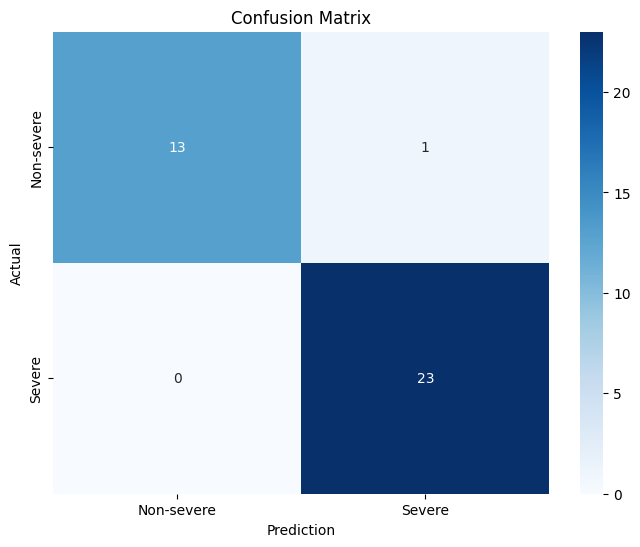

[[13  1]
 [ 0 23]]


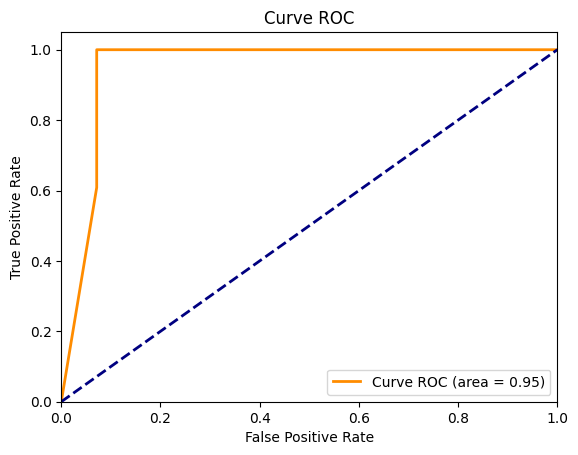

<function roc_curve at 0x7f75f11a1f30>


In [48]:
#Ajuste de hiperparámetros con Random Search
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el modelo de Random Forest
rf = RandomForestClassifier(random_state=42)

# Configurar Random Search con validación cruzada
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, scoring='roc_auc', verbose=2, random_state=42)

# Ejecutar Random Search
random_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_rf = random_search.best_estimator_

# Realizar predicciones con el mejor modelo
y_pred_best_rf = best_rf.predict(X_test)
y_prob_best_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluar el mejor modelo
classification_rep_best_rf = classification_report(y_test, y_pred_best_rf)
roc_auc_best_rf = roc_auc_score(y_test, y_prob_best_rf)

classification_rep_best_rf, roc_auc_best_rf
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_best_rf)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-severe', 'Severe'], yticklabels=['Non-severe', 'Severe'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()
print(conf_matrix)
plt.close()

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_best_rf)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curve ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curve ROC')
plt.legend(loc="lower right")
plt.savefig('roc_curve1.png')
plt.show(roc_curve)
print(roc_curve)


Gradient Boosting

In [49]:
#Entrenamiento y evaluación del modelo de
from sklearn.ensemble import GradientBoostingClassifier

# Entrenar el modelo de Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Realizar predicciones
y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]

# Evaluar el modelo
classification_rep_gb = classification_report(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_prob_gb)

classification_rep_gb, roc_auc_gb


('              precision    recall  f1-score   support\n\n           0       1.00      0.93      0.96        14\n           1       0.96      1.00      0.98        23\n\n    accuracy                           0.97        37\n   macro avg       0.98      0.96      0.97        37\nweighted avg       0.97      0.97      0.97        37\n',
 0.953416149068323)

In [50]:
# Extraer características temporales
data['mes'] = data['fecha'].dt.month
data['dia_semana'] = data['fecha'].dt.dayofweek

# Volver a seleccionar características y objetivo
features = data.drop(columns=['fecha', 'gravedad'])
target = data['gravedad']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Entrenar el modelo de Gradient Boosting con las nuevas características
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Realizar predicciones
y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]

# Evaluar el modelo
classification_rep_gb = classification_report(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_prob_gb)

classification_rep_gb, roc_auc_gb


('              precision    recall  f1-score   support\n\n           0       0.81      0.93      0.87        14\n           1       0.95      0.87      0.91        23\n\n    accuracy                           0.89        37\n   macro avg       0.88      0.90      0.89        37\nweighted avg       0.90      0.89      0.89        37\n',
 0.9891304347826088)

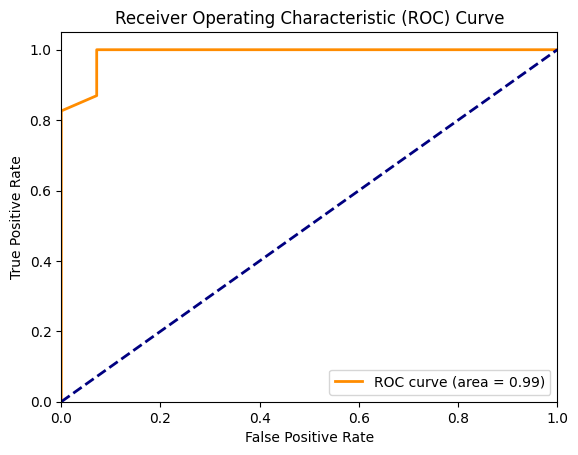

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_gb)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()


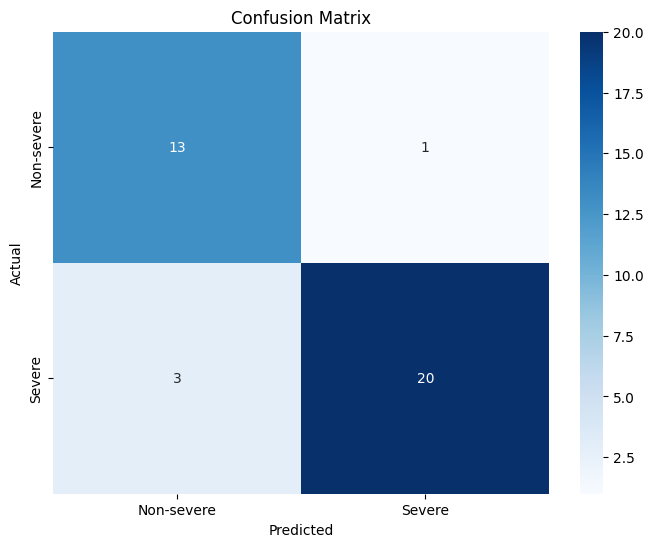

[[13  1]
 [ 3 20]]


In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_gb)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-severe', 'Severe'], yticklabels=['Non-severe', 'Severe'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()
print(conf_matrix)
